# Predict Bike Sharing Demand with AutoGluon Template

## Project: Predict Bike Sharing Demand with AutoGluon

1. Notebook using a `ml.t3.medium` instance (2 vCPU + 4 GiB)
2. Notebook using kernel: `Python 3 (MXNet 1.8 Python 3.7 CPU Optimized)`

### Install packages

In [1]:
!pip install -U pip
!pip install -U setuptools wheel
#!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing
!pip install kaggle

,Requirement already satisfied: setuptools in /opt/conda/lib/python3.12/site-packages (80.8.0)
,Requirement already satisfied: wheel in /opt/conda/lib/python3.12/site-packages (0.45.1)
,Requirement already satisfied: autogluon in /opt/conda/lib/python3.12/site-packages (1.2)
,Requirement already satisfied: autogluon.core==1.2 in /opt/conda/lib/python3.12/site-packages (from autogluon.core[all]==1.2->autogluon) (1.2)
,Requirement already satisfied: autogluon.features==1.2 in /opt/conda/lib/python3.12/site-packages (from autogluon) (1.2)
,Requirement already satisfied: autogluon.tabular==1.2 in /opt/conda/lib/python3.12/site-packages (from autogluon.tabular[all]==1.2->autogluon) (1.2)
,Requirement already satisfied: autogluon.multimodal==1.2 in /opt/conda/lib/python3.12/site-packages (from autogluon) (1.2)
,Requirement already satisfied: autogluon.timeseries==1.2 in /opt/conda/lib/python3.12/site-packages (from autogluon.timeseries[all]==1.2->autogluon) (1.2)
,Requirement already satisfi

### Setup Kaggle API Key

In [3]:
# Creating directory in the user's home directory
!mkdir -p ~/.kaggle

# Create the kaggle.json file
!touch ~/.kaggle/kaggle.json

# Set the correct permissions for the file
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Fills in username and key from creating the kaggle account and API token file
import json
import os

#replace placeholder below with user and API token from Kaggle account
kaggle_username = "youruser"
kaggle_key = "yourAPItoken"

kaggle_json_path = os.path.expanduser("~/.kaggle/kaggle.json")
kaggle_json_path

# Save API token the kaggle.json file
with open(kaggle_json_path, "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Download and explore dataset

In [6]:
# Downloading the dataset in compressed format (.zip)
!kaggle competitions download -c bike-sharing-demand
# Unzipping file. If already downloaded, the -o command overwrites the existing file
!unzip -o bike-sharing-demand.zip

,  0%|                                                | 0.00/189k [00:00<?, ?B/s]
,100%|█████████████████████████████████████████| 189k/189k [00:00<00:00, 714MB/s]
,Archive:  bike-sharing-demand.zip
,  inflating: sampleSubmission.csv    
,  inflating: test.csv                
,  inflating: train.csv               


In [7]:
# checks installation of autogluon
import pandas as pd
from autogluon.tabular import TabularPredictor

In [8]:
# Creates the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so some of the `dt` features can be used in pandas later
train = pd.read_csv("train.csv",parse_dates=["datetime"])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [9]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2011-12-27 05:56:22.399411968,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
min,2011-01-01 00:00:00,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2011-07-02 07:15:00,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,2012-01-01 20:30:00,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,2012-07-01 12:45:00,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,2012-12-19 23:00:00,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000
std,NaN,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454


In [10]:
# Getting info regarding the datatypes present in the train dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 10886 entries, 0 to 10885
,Data columns (total 12 columns):
, #   Column      Non-Null Count  Dtype         
,---  ------      --------------  -----         
, 0   datetime    10886 non-null  datetime64[ns]
, 1   season      10886 non-null  int64         
, 2   holiday     10886 non-null  int64         
, 3   workingday  10886 non-null  int64         
, 4   weather     10886 non-null  int64         
, 5   temp        10886 non-null  float64       
, 6   atemp       10886 non-null  float64       
, 7   humidity    10886 non-null  int64         
, 8   windspeed   10886 non-null  float64       
, 9   casual      10886 non-null  int64         
, 10  registered  10886 non-null  int64         
, 11  count       10886 non-null  int64         
,dtypes: datetime64[ns](1), float64(3), int64(8)
,memory usage: 1020.7 KB


In [11]:
# Creates the test pandas dataframe in pandas by reading the csv. Also parsing the datetime
test = pd.read_csv("test.csv",parse_dates=["datetime"])
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [12]:
# Creates the submission pandas dataframe in pandas by reading the csv. Also parsing the datetime
submission = pd.read_csv("sampleSubmission.csv",parse_dates=["datetime"])
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are predicting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [13]:
predictor = TabularPredictor(label="count", eval_metric="root_mean_squared_error", learner_kwargs={'ignored_columns': ['casual', 'registered']}).fit(train_data=train, time_limit=600, presets="best_quality")

No path specified. Models will be saved in: "AutogluonModels/ag-20250523_152046"
,Verbosity: 2 (Standard Logging)
,=================== System Info ===================
,AutoGluon Version:  1.2
,Python Version:     3.12.9
,Operating System:   Linux
,Platform Machine:   x86_64
,Platform Version:   #1 SMP Sat Apr 19 16:54:57 UTC 2025
,CPU Count:          2
,Memory Avail:       1.72 GB / 3.76 GB (45.8%)
,Disk Space Avail:   3.09 GB / 4.99 GB (62.0%)
,	WARNING: Available disk space is low and there is a risk that AutoGluon will run out of disk during fit, causing an exception. 
,	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
,===================================================
,Presets specified: ['best_quality']
,Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
,Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
,DyStack 

(_ray_fit pid=21602) [1000]	valid_set's rmse: 130.657
,(_ray_fit pid=21719) [1000]	valid_set's rmse: 132.725 [repeated 5x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
,(_ray_fit pid=21753) [2000]	valid_set's rmse: 126.702 [repeated 2x across cluster]
,(_ray_fit pid=21791) [2000]	valid_set's rmse: 134.443 [repeated 5x across cluster]
,(_ray_fit pid=21753) [9000]	valid_set's rmse: 125.618 [repeated 7x across cluster]
,(_ray_fit pid=21791) [9000]	valid_set's rmse: 132.422 [repeated 4x across cluster]
,(_ray_fit pid=21832) [1000]	valid_set's rmse: 137.712
,(_ray_fit pid=21832) [2000]	valid_set's rmse: 136.347
,(_ray_fit pid=21832) [3000]	valid_set's rmse: 135.865
,(_ray_fit pid=21832) [4000]	valid_set's rmse: 135.344
,(_ray_fit pid=21832) [5000]	valid_set's rmse: 135.358
,(_ray_fit pid=21869) [1000]	valid_set

(_dystack pid=21462) 	-131.9758	 = Validation score   (-root_mean_squared_error)
,(_dystack pid=21462) 	66.58s	 = Training   runtime
,(_dystack pid=21462) 	10.46s	 = Validation runtime
,(_dystack pid=21462) Fitting model: LightGBM_BAG_L1 ... Training model for up to 23.03s of the 71.45s of remaining time.
,(_dystack pid=21462) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=1.12%)


(_ray_fit pid=21915) [1000]	valid_set's rmse: 129.285
,(_ray_fit pid=21916) [1000]	valid_set's rmse: 129.274
,(_ray_fit pid=21984) [1000]	valid_set's rmse: 135.098
,(_ray_fit pid=22052) [1000]	valid_set's rmse: 124.896
,(_ray_fit pid=22120) [1000]	valid_set's rmse: 134.479 [repeated 2x across cluster]


(_dystack pid=21462) 	-131.8496	 = Validation score   (-root_mean_squared_error)
,(_dystack pid=21462) 	29.28s	 = Training   runtime
,(_dystack pid=21462) 	1.24s	 = Validation runtime
,(_dystack pid=21462) Fitting model: WeightedEnsemble_L2 ... Training model for up to 145.22s of the 37.75s of remaining time.
,(_dystack pid=21462) 	Ensemble Weights: {'KNeighborsDist_BAG_L1': 1.0}
,(_dystack pid=21462) 	-89.9469	 = Validation score   (-root_mean_squared_error)
,(_dystack pid=21462) 	0.03s	 = Training   runtime
,(_dystack pid=21462) 	0.0s	 = Validation runtime
,(_dystack pid=21462) Fitting 106 L2 models, fit_strategy="sequential" ...
,(_dystack pid=21462) Fitting model: LightGBMXT_BAG_L2 ... Training model for up to 37.71s of the 37.51s of remaining time.
,(_dystack pid=21462) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=1.00%)


(_ray_fit pid=22190) [1000]	valid_set's rmse: 68.8067 [repeated 2x across cluster]
,(_ray_fit pid=22260) [1000]	valid_set's rmse: 78.2341 [repeated 2x across cluster]
,(_ray_fit pid=22348) [1000]	valid_set's rmse: 75.8581 [repeated 2x across cluster]
,(_ray_fit pid=22420) [1000]	valid_set's rmse: 71.9787 [repeated 2x across cluster]


(_dystack pid=21462) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
,(_dystack pid=21462) I0000 00:00:1748013801.240926   21511 chttp2_transport.cc:1182] ipv4:169.255.255.2:38355: Got goaway [2] err=UNAVAILABLE:GOAWAY received; Error code: 2; Debug Text: Cancelling all calls {grpc_status:14, http2_error:2, created_time:"2025-05-23T15:23:21.24091269+00:00"}
,(_dystack pid=21462) 	-73.6831	 = Validation score   (-root_mean_squared_error)
,(_dystack pid=21462) 	35.89s	 = Training   runtime
,(_dystack pid=21462) 	2.2s	 = Validation runtime
,(_dystack pid=21462) Fitting model: WeightedEnsemble_L3 ... Training model for up to 145.22s of the -2.50s of remaining time.
,(_dystack pid=21462) 	Ensemble Weights: {'LightGBMXT_BAG_L2': 0.958, 'KNeighborsDist_BAG_L1': 0.042}
,(_dystack pid=21462) 	-73.6478	 = Validation score   (-root_mean_squared_error)
,(_dystack pid=21462) 	0.03s	 = Training   runtime
,(_dystack pid=21462) 	0.0s	 = Validation runtime
,(_dyst

### Review AutoGluon's training run with ranking of models that did the best.

In [15]:
predictor.fit_summary()

*** Summary of fit() ***
,Estimated performance of each model:
,                     model   score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
,0      WeightedEnsemble_L3  -53.344306  root_mean_squared_error      19.776258  400.540409                0.000700           0.032864            3       True         13
,1   RandomForestMSE_BAG_L2  -53.803638  root_mean_squared_error      14.917177  315.732064                0.312223          19.396812            2       True         12
,2          LightGBM_BAG_L2  -55.220775  root_mean_squared_error      14.845964  323.639740                0.241010          27.304488            2       True         11
,3        LightGBMXT_BAG_L2  -60.656450  root_mean_squared_error      19.222325  353.806245                4.617372          57.470993            2       True         10
,4    KNeighborsDist_BAG_L1  -84.125061  root_mean_squared_error       0.055116    0.03

/opt/conda/lib/python3.12/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
,  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -131.46090891834504,
  'LightGBM_BAG_L1': -131.054161598899,
  'RandomForestMSE_BAG_L1': -117.18644731915069,
  'CatBoost_BAG_L1': -130.71008953095804

<Axes: xlabel='model'>

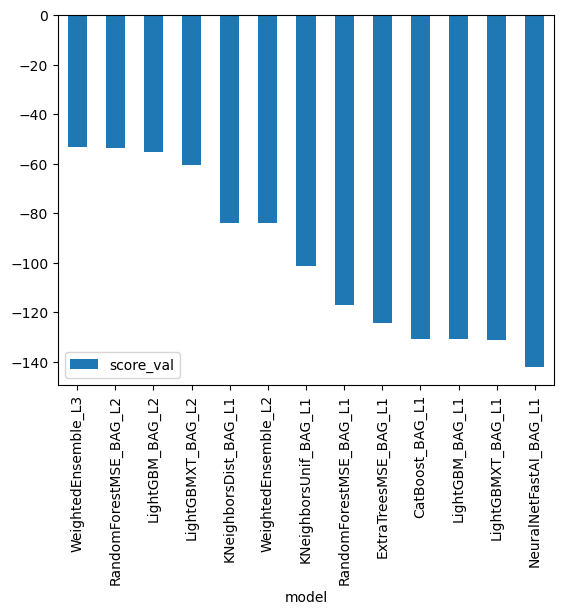

In [16]:
# Above code output results and leaderboard
# Code below outputs a more visually appealing leaderboard, with horizontal bar plot which is clearer for long model names
predictor.leaderboard(silent=True).plot(kind="bar",x="model",y="score_val")

In [17]:
# Outputs leaderboard of top 5 models
predictor.leaderboard(silent=True).nlargest(5, "score_val")

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-53.344306,root_mean_squared_error,19.776258,400.540409,0.000700,0.032864,3,True,13
1,RandomForestMSE_BAG_L2,-53.803638,root_mean_squared_error,14.917177,315.732064,0.312223,19.396812,2,True,12
2,LightGBM_BAG_L2,-55.220775,root_mean_squared_error,14.845964,323.639740,0.241010,27.304488,2,True,11
3,LightGBMXT_BAG_L2,-60.656450,root_mean_squared_error,19.222325,353.806245,4.617372,57.470993,2,True,10
4,KNeighborsDist_BAG_L1,-84.125061,root_mean_squared_error,0.055116,0.038233,0.055116,0.038233,1,True,2


/tmp/ipykernel_20562/4114484977.py:6: FutureWarning: 
,
,Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.
,
,  sns.barplot(x="score_val", y="model", palette="viridis", data=predictor.leaderboard(silent=True)).set_title("Models Leaderboard")


Text(0.5, 1.0, 'Models Leaderboard')

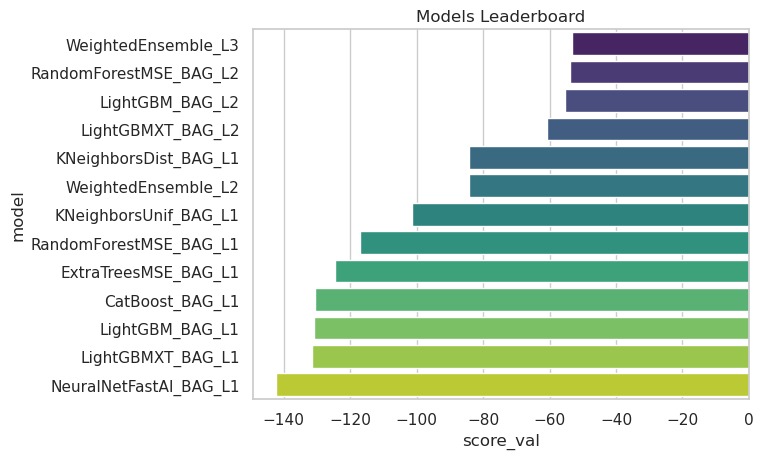

In [18]:
# Import seaborn lib for better data visualization
import seaborn as sns
# Setting plot style
sns.set(context="notebook", style="whitegrid")
# Seaborn barplot leaderboard
sns.barplot(x="score_val", y="model", palette="viridis", data=predictor.leaderboard(silent=True)).set_title("Models Leaderboard")

### Create predictions from test dataset

In [21]:
predictions = predictor.predict(test)
predictions.head()

/opt/conda/lib/python3.12/site-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
,If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
,  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")
,/opt/conda/lib/python3.12/site-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
,If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
,  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files 

0    23.385082
1    41.503433
2    44.151543
3    46.415962
4    49.295509
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [20]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      100.799942
std        90.029907
min         3.002777
25%        19.607986
50%        63.924118
75%       167.785812
max       369.399902
Name: count, dtype: float64

In [22]:
# Count how many negative values are present and prints it to the screen
negative_values = (predictions < 0).sum()
print("Negative predictions number: ", negative_values)

Negative predictions number:  0


In [23]:
# If any negative values existed in the predictions, the following would set them to 0
predictions[predictions < 0] = 0

### Set predictions to submission dataframe, save, and submit

In [24]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [25]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 772kB/s]
,Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [26]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                        description                        status                     publicScore  privateScore  
,---------------------------  --------------------------  ---------------------------------  -------------------------  -----------  ------------  
,submission.csv               2025-05-23 15:35:30.210000  first raw submission               SubmissionStatus.COMPLETE  1.79901      1.79901       
,submission_new_hpo.csv       2025-05-23 12:41:58.060000  new features with hyperparameters  SubmissionStatus.COMPLETE  0.49034      0.49034       
,submission_new_features.csv  2025-05-23 12:10:55.410000  new features                       SubmissionStatus.COMPLETE  0.49614      0.49614       
,submission.csv               2025-05-23 11:04:51.317000  first raw submission               SubmissionStatus.COMPLETE  1.79592      1.79592       


#### Initial score of `1.79`

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

array([[<Axes: title={'center': 'datetime'}>,
        <Axes: title={'center': 'season'}>,
        <Axes: title={'center': 'holiday'}>],
       [<Axes: title={'center': 'workingday'}>,
        <Axes: title={'center': 'weather'}>,
        <Axes: title={'center': 'temp'}>],
       [<Axes: title={'center': 'atemp'}>,
        <Axes: title={'center': 'humidity'}>,
        <Axes: title={'center': 'windspeed'}>],
       [<Axes: title={'center': 'casual'}>,
        <Axes: title={'center': 'registered'}>,
        <Axes: title={'center': 'count'}>]], dtype=object)

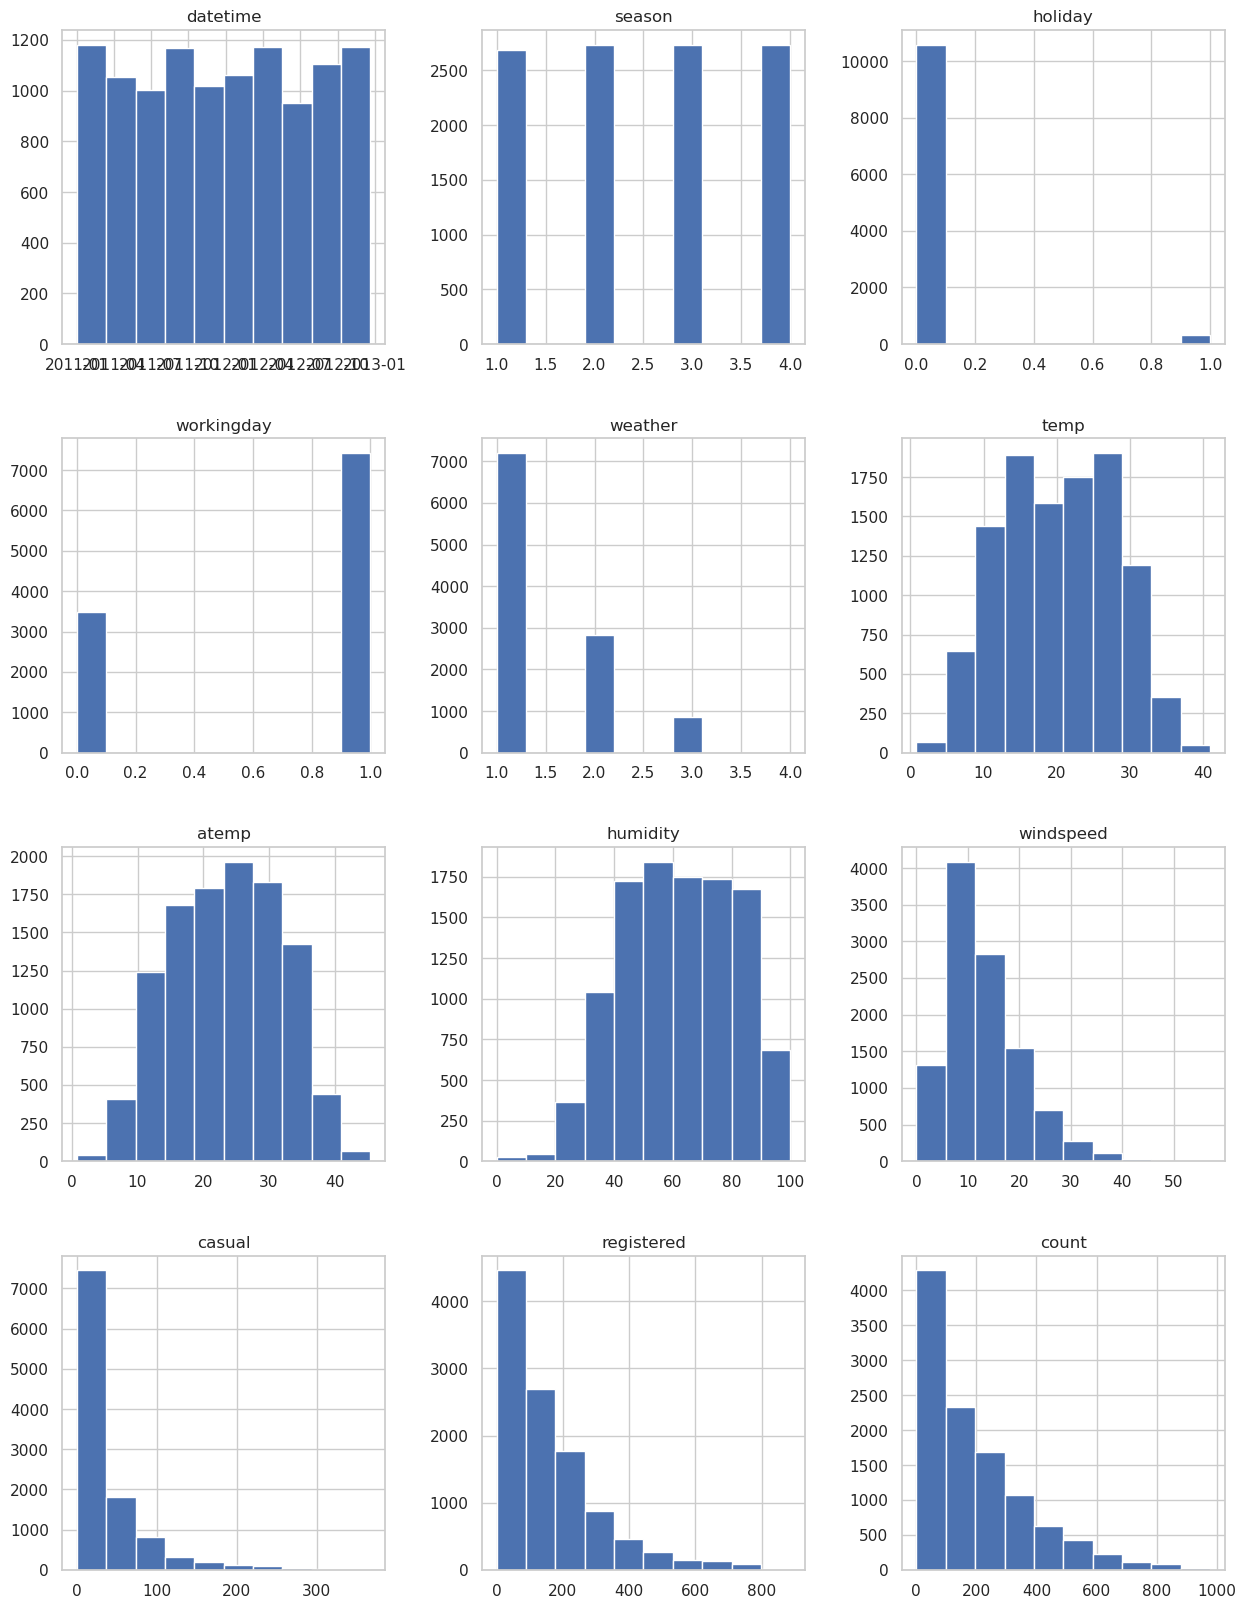

In [ ]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploratory data analysis
train.hist(figsize=(15,20))

In [28]:
# As also shown above, datetime does not currently separate hour, year, month or day 
# This type of data could be useful features to take into account
# Create a new feature for train data
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
# Drop the datetime column
train.drop(["datetime"], axis=1, inplace=True) 
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


In [29]:
# Create a new feature for test data
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["day"] = test["datetime"].dt.day  
test["hour"] = test["datetime"].dt.hour
test.drop(["datetime"], axis=1, inplace=True)
test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour
0,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,0
1,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,1
2,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,2
3,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3
4,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,4


In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 10886 entries, 0 to 10885
,Data columns (total 15 columns):
, #   Column      Non-Null Count  Dtype  
,---  ------      --------------  -----  
, 0   season      10886 non-null  int64  
, 1   holiday     10886 non-null  int64  
, 2   workingday  10886 non-null  int64  
, 3   weather     10886 non-null  int64  
, 4   temp        10886 non-null  float64
, 5   atemp       10886 non-null  float64
, 6   humidity    10886 non-null  int64  
, 7   windspeed   10886 non-null  float64
, 8   casual      10886 non-null  int64  
, 9   registered  10886 non-null  int64  
, 10  count       10886 non-null  int64  
, 11  year        10886 non-null  int32  
, 12  month       10886 non-null  int32  
, 13  day         10886 non-null  int32  
, 14  hour        10886 non-null  int32  
,dtypes: float64(3), int32(4), int64(8)
,memory usage: 1.1 MB


## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [31]:
train["season"] = train["season"].astype('category')
train["weather"] = train["weather"].astype('category')
test["season"] = test["season"].astype('category')
test["weather"] = test["weather"].astype('category')

In [32]:
# View the new features
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


array([[<Axes: title={'center': 'holiday'}>,
        <Axes: title={'center': 'workingday'}>,
        <Axes: title={'center': 'temp'}>,
        <Axes: title={'center': 'atemp'}>],
       [<Axes: title={'center': 'humidity'}>,
        <Axes: title={'center': 'windspeed'}>,
        <Axes: title={'center': 'casual'}>,
        <Axes: title={'center': 'registered'}>],
       [<Axes: title={'center': 'count'}>,
        <Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'month'}>,
        <Axes: title={'center': 'day'}>],
       [<Axes: title={'center': 'hour'}>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

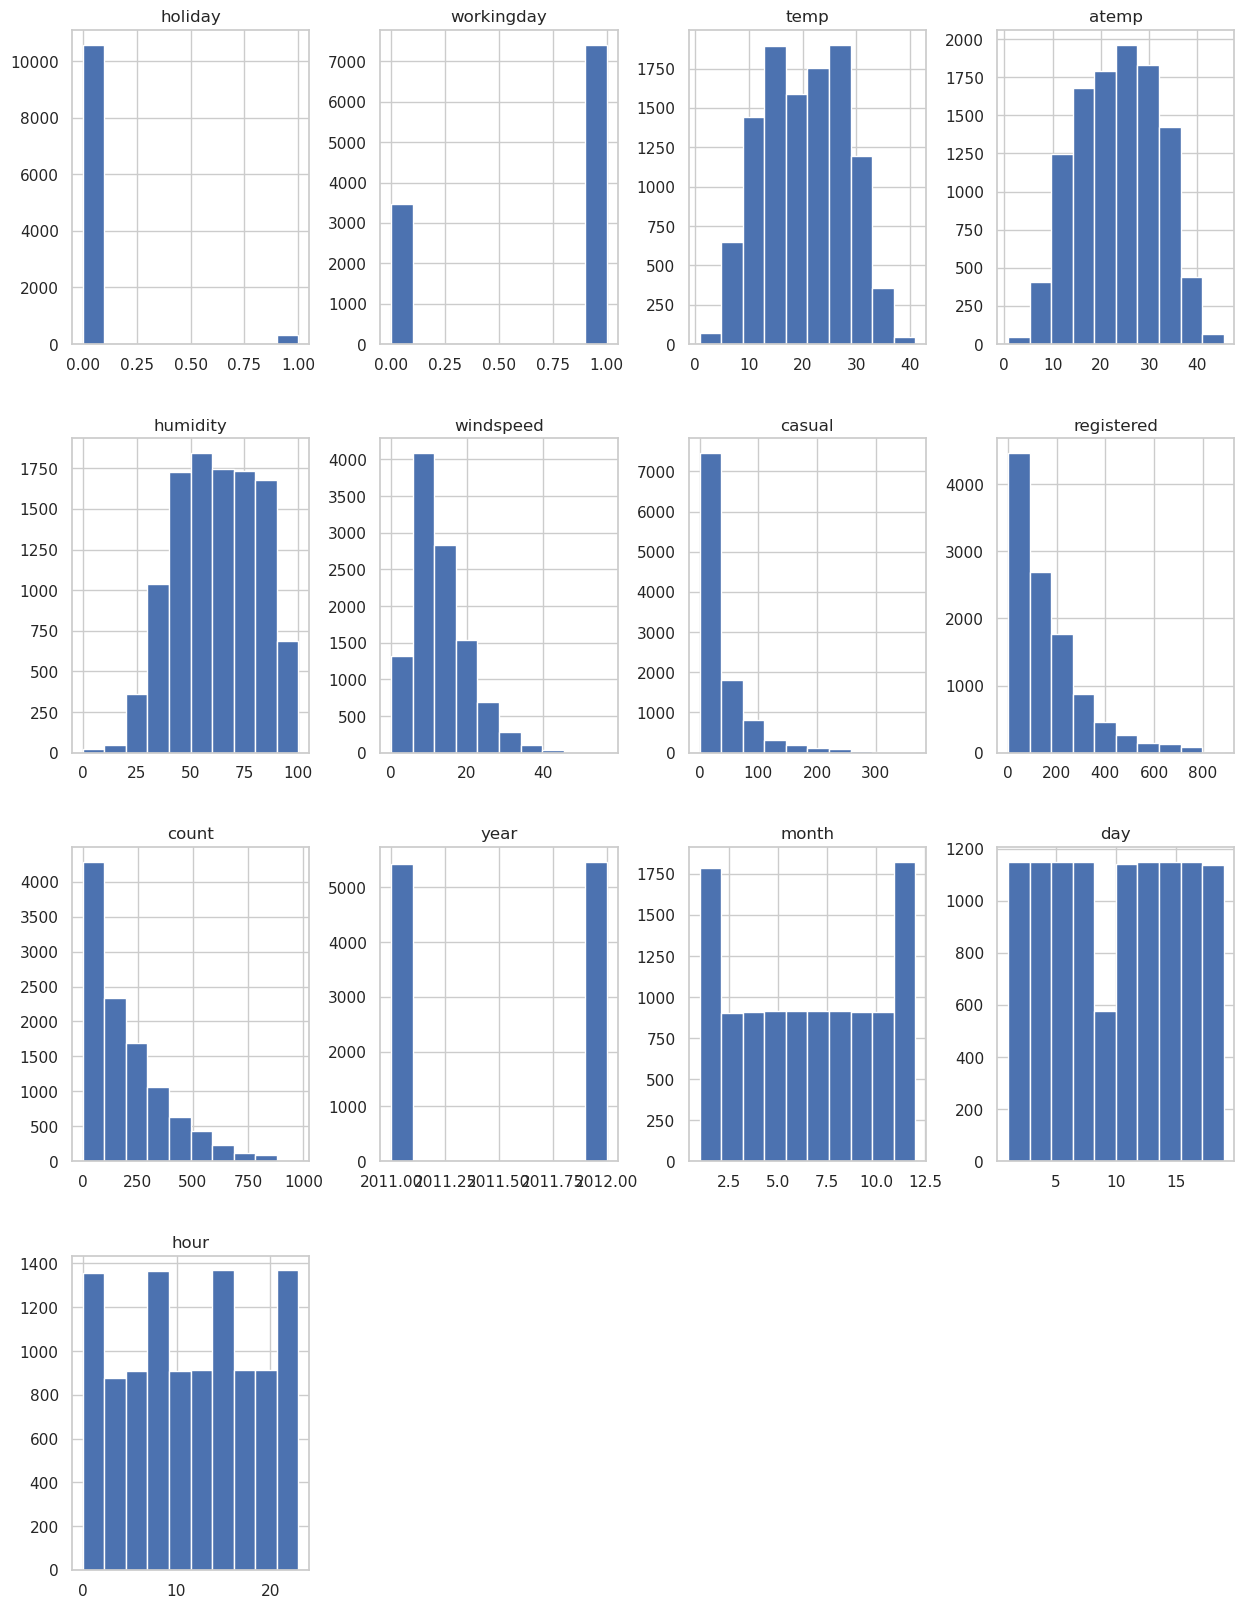

In [33]:
# View histogram of all features again now with the hour feature
train.hist(figsize=(15,20))

## Step 5: Rerun the model with the same settings as before, just with more features

In [34]:
predictor_new_features = TabularPredictor(label="count", eval_metric="root_mean_squared_error", learner_kwargs={'ignored_columns': ['casual', 'registered']}).fit(train_data=train, time_limit=600, presets="best_quality")

No path specified. Models will be saved in: "AutogluonModels/ag-20250523_153753"
,Verbosity: 2 (Standard Logging)
,=================== System Info ===================
,AutoGluon Version:  1.2
,Python Version:     3.12.9
,Operating System:   Linux
,Platform Machine:   x86_64
,Platform Version:   #1 SMP Sat Apr 19 16:54:57 UTC 2025
,CPU Count:          2
,Memory Avail:       0.63 GB / 3.76 GB (16.8%)
,Disk Space Avail:   2.38 GB / 4.99 GB (47.7%)
,	WARNING: Available disk space is low and there is a risk that AutoGluon will run out of disk during fit, causing an exception. 
,	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
,===================================================
,Presets specified: ['best_quality']
,Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
,Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
,DyStack 

In [35]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
,Estimated performance of each model:
,                   model   score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
,0    WeightedEnsemble_L2  -38.096866  root_mean_squared_error       0.622050  205.805530                0.000614           0.028514            2       True          6
,1    WeightedEnsemble_L3  -38.096866  root_mean_squared_error       0.622206  205.819773                0.000770           0.042758            3       True          8
,2     CatBoost_r9_BAG_L1  -38.231446  root_mean_squared_error       0.433955  203.776635                0.433955         203.776635            1       True          5
,3   ExtraTreesMSE_BAG_L1  -42.565150  root_mean_squared_error       0.187481    2.000381                0.187481           2.000381            1       True          3
,4  KNeighborsDist_BAG_L1 -119.365601  root_mean_squared_error       0.206013    0.030573        

/opt/conda/lib/python3.12/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
,  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'CatBoost_r9_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'XGBoost_BAG_L2': 'StackerEnsembleModel_XGBoost',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -123.93326033133259,
  'KNeighborsDist_BAG_L1': -119.36560130583281,
  'ExtraTreesMSE_BAG_L1': -42.56515017419128,
  'XGBoost_BAG_L1': -168.93950228116285,
  'CatBoost_r9_BAG_L1': -38.231446039364734,
  'WeightedEnsemble_L2': -38.096866334342806,
  'XGBoost_BAG_L2': -164.01241950553168,
  'WeightedEnsemble_L3': -38.096866334342806},
 'model_best': 'WeightedEnsemble_L2',
 'model_paths': {'KNeighborsUnif_BAG_L1': ['KNeighborsUnif_BAG_L1'],
  'KNeighborsDist_BAG_L1': ['KNeighborsDist_BAG_L1'],
  'ExtraTreesMSE

<Axes: xlabel='model'>

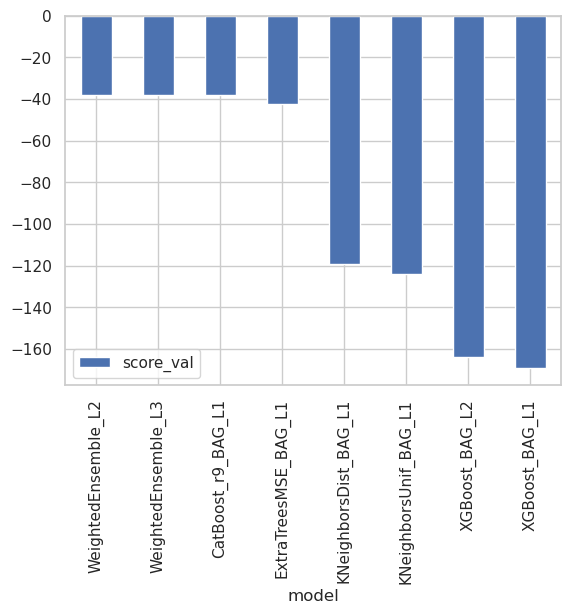

In [36]:
predictor_new_features.leaderboard(silent=True).plot(kind="bar",x="model",y="score_val")

In [37]:
predictor_new_features.leaderboard(silent=True).nlargest(5, "score_val")

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-38.096866,root_mean_squared_error,0.622050,205.805530,0.000614,0.028514,2,True,6
1,WeightedEnsemble_L3,-38.096866,root_mean_squared_error,0.622206,205.819773,0.000770,0.042758,3,True,8
2,CatBoost_r9_BAG_L1,-38.231446,root_mean_squared_error,0.433955,203.776635,0.433955,203.776635,1,True,5
3,ExtraTreesMSE_BAG_L1,-42.565150,root_mean_squared_error,0.187481,2.000381,0.187481,2.000381,1,True,3
4,KNeighborsDist_BAG_L1,-119.365601,root_mean_squared_error,0.206013,0.030573,0.206013,0.030573,1,True,2


/tmp/ipykernel_20562/863463927.py:3: FutureWarning: 
,
,Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.
,
,  sns.barplot(x="score_val", y="model", palette="viridis", data=predictor_new_features.leaderboard(silent=True)).set_title("Models Leaderboard - New Features")


Text(0.5, 1.0, 'Models Leaderboard - New Features')

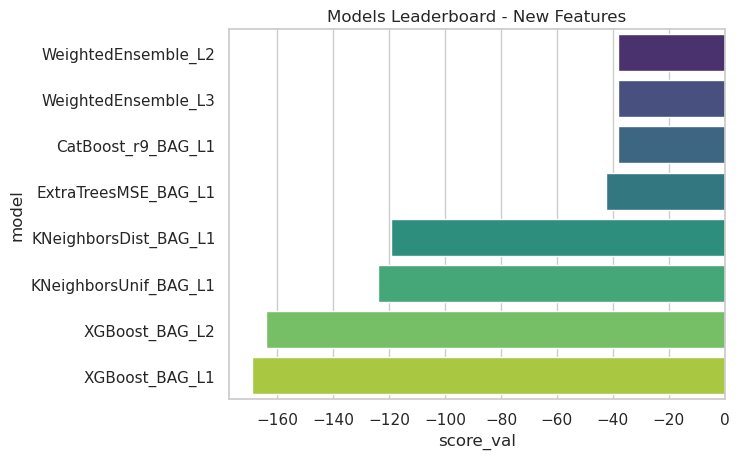

In [38]:
sns.set(context="notebook", style="whitegrid")
sns.barplot(x="score_val", y="model", palette="viridis", data=predictor_new_features.leaderboard(silent=True)).set_title("Models Leaderboard - New Features")

In [39]:
# Remember to set all negative values to zero
predictions_new_features = predictor_new_features.predict(test)
predictions_new_features[predictions_new_features < 0] = 0

In [40]:
# Same submitting predictions
submission_new_features = pd.read_csv('sampleSubmission.csv', parse_dates = ['datetime'])
submission_new_features.head()
submission_new_features["count"] = predictions_new_features
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [41]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 759kB/s]
,Successfully submitted to Bike Sharing Demand

In [42]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                        description                        status                     publicScore  privateScore  
,---------------------------  --------------------------  ---------------------------------  -------------------------  -----------  ------------  
,submission_new_features.csv  2025-05-23 15:50:06.327000  new features                       SubmissionStatus.COMPLETE  0.49571      0.49571       
,submission.csv               2025-05-23 15:35:30.210000  first raw submission               SubmissionStatus.COMPLETE  1.79901      1.79901       
,submission_new_hpo.csv       2025-05-23 12:41:58.060000  new features with hyperparameters  SubmissionStatus.COMPLETE  0.49034      0.49034       
,submission_new_features.csv  2025-05-23 12:10:55.410000  new features                       SubmissionStatus.COMPLETE  0.49614      0.49614       


#### New Score of `0.49`

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [45]:
import autogluon.common as ag

In [48]:
# Low memory issue, these options were used in first few instances of the project but then a different approach was taken
'''nn_options = {
    'num_epochs': 10,
    'learning_rate': ag.space.Real(1e-4, 1e-2, default=5e-4, log=True),
    'activation': ag.space.Categorical('relu', 'softrelu', 'tanh'),
    'layers': ag.space.Categorical([100],[1000],[200,100],[300,200,100]),
    'dropout_prob': ag.space.Real(0.0, 0.5, default=0.1),
}

gbm_options = {
    'num_boost_round': 100,
    'num_leaves': ag.space.Int(lower=26, upper=66, default=36)
}

hyperparameters = {
    'GBM': gbm_options,
    'CAT': {'iterations': 10000},
    'RF': {'n_estimators': 300},
    'XT': {'n_estimators': 300}
} 

hyperparameter_tune_kwargs = { 
    'scheduler': 'local',
    'searcher': 'search_strategy' 
}'''

In [50]:
configs = [
    {'name': 'GBM', 'params': {'GBM': {'num_boost_round': 100, 'num_leaves': 36}}},
    {'name': 'CAT', 'params': {'CAT': {'iterations': 500}}},
    {'name': 'RF',  'params': {'RF': {'n_estimators': 200}}},
    {'name': 'XT',  'params': {'XT': {'n_estimators': 200}}},
]


In [51]:
# Low memory issue, this loops through one config at a time training one model each time
results = []

for cfg in configs:
    print(f"Training model: {cfg['name']}")
    predictor = TabularPredictor(label="count", eval_metric="root_mean_squared_error").fit(
        train_data=train,
        hyperparameters=cfg['params'],
        ag_args_fit={"num_cpus": 1, "num_gpus": 0}
    )
    score = predictor.leaderboard(silent=True)['score_val'][0]
    results.append((cfg['name'], score))


No path specified. Models will be saved in: "AutogluonModels/ag-20250523_160112"
,Verbosity: 2 (Standard Logging)
,=================== System Info ===================
,AutoGluon Version:  1.2
,Python Version:     3.12.9
,Operating System:   Linux
,Platform Machine:   x86_64
,Platform Version:   #1 SMP Sat Apr 19 16:54:57 UTC 2025
,CPU Count:          2
,Memory Avail:       0.54 GB / 3.76 GB (14.3%)
,Disk Space Avail:   1.80 GB / 4.99 GB (36.1%)
,	WARNING: Available disk space is low and there is a risk that AutoGluon will run out of disk during fit, causing an exception. 
,	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
,===================================================
,No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
,	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
,	pr

Training model: GBM


	-3.1206	 = Validation score   (-root_mean_squared_error)
,	0.71s	 = Training   runtime
,	0.01s	 = Validation runtime
,Fitting model: WeightedEnsemble_L2 ...
,	Ensemble Weights: {'LightGBM': 1.0}
,	-3.1206	 = Validation score   (-root_mean_squared_error)
,	0.0s	 = Training   runtime
,	0.0s	 = Validation runtime
,AutoGluon training complete, total runtime = 0.9s ... Best model: WeightedEnsemble_L2 | Estimated inference throughput: 111652.6 rows/s (1089 batch size)
,TabularPredictor saved. To load, use: predictor = TabularPredictor.load("/home/sagemaker-user/nd009t-c1-intro-to-ml-project-starter/AutogluonModels/ag-20250523_160112")
,No path specified. Models will be saved in: "AutogluonModels/ag-20250523_160113"
,Verbosity: 2 (Standard Logging)
,=================== System Info ===================
,AutoGluon Version:  1.2
,Python Version:     3.12.9
,Operating System:   Linux
,Platform Machine:   x86_64
,Platform Version:   #1 SMP Sat Apr 19 16:54:57 UTC 2025
,CPU Count:          2
,Memor

Training model: CAT


	-3.0874	 = Validation score   (-root_mean_squared_error)
,	4.25s	 = Training   runtime
,	0.01s	 = Validation runtime
,Fitting model: WeightedEnsemble_L2 ...
,	Ensemble Weights: {'CatBoost': 1.0}
,	-3.0874	 = Validation score   (-root_mean_squared_error)
,	0.0s	 = Training   runtime
,	0.0s	 = Validation runtime
,AutoGluon training complete, total runtime = 4.4s ... Best model: WeightedEnsemble_L2 | Estimated inference throughput: 141127.7 rows/s (1089 batch size)
,TabularPredictor saved. To load, use: predictor = TabularPredictor.load("/home/sagemaker-user/nd009t-c1-intro-to-ml-project-starter/AutogluonModels/ag-20250523_160113")
,No path specified. Models will be saved in: "AutogluonModels/ag-20250523_160117"
,Verbosity: 2 (Standard Logging)
,=================== System Info ===================
,AutoGluon Version:  1.2
,Python Version:     3.12.9
,Operating System:   Linux
,Platform Machine:   x86_64
,Platform Version:   #1 SMP Sat Apr 19 16:54:57 UTC 2025
,CPU Count:          2
,Memor

Training model: RF


,	-2.6863	 = Validation score   (-root_mean_squared_error)
,	6.76s	 = Training   runtime
,	0.08s	 = Validation runtime
,Fitting model: WeightedEnsemble_L2 ...
,	Ensemble Weights: {'RandomForest': 1.0}
,	-2.6863	 = Validation score   (-root_mean_squared_error)
,	0.0s	 = Training   runtime
,	0.0s	 = Validation runtime
,AutoGluon training complete, total runtime = 7.13s ... Best model: WeightedEnsemble_L2 | Estimated inference throughput: 13789.8 rows/s (1089 batch size)
,TabularPredictor saved. To load, use: predictor = TabularPredictor.load("/home/sagemaker-user/nd009t-c1-intro-to-ml-project-starter/AutogluonModels/ag-20250523_160117")
,No path specified. Models will be saved in: "AutogluonModels/ag-20250523_160124"
,Verbosity: 2 (Standard Logging)
,=================== System Info ===================
,AutoGluon Version:  1.2
,Python Version:     3.12.9
,Operating System:   Linux
,Platform Machine:   x86_64
,Platform Version:   #1 SMP Sat Apr 19 16:54:57 UTC 2025
,CPU Count:          2
,

Training model: XT


,	-2.6292	 = Validation score   (-root_mean_squared_error)
,	3.44s	 = Training   runtime
,	0.07s	 = Validation runtime
,Fitting model: WeightedEnsemble_L2 ...
,	Ensemble Weights: {'ExtraTrees': 1.0}
,	-2.6292	 = Validation score   (-root_mean_squared_error)
,	0.0s	 = Training   runtime
,	0.0s	 = Validation runtime
,AutoGluon training complete, total runtime = 3.73s ... Best model: WeightedEnsemble_L2 | Estimated inference throughput: 16546.4 rows/s (1089 batch size)
,TabularPredictor saved. To load, use: predictor = TabularPredictor.load("/home/sagemaker-user/nd009t-c1-intro-to-ml-project-starter/AutogluonModels/ag-20250523_160124")


In [62]:
#this was used in previous cycles but the code in cells above allowed to find a workaround for the memory issue
#predictor_new_hpo = TabularPredictor(label="count", verbosity=0, eval_metric='root_mean_squared_error', learner_kwargs={"ignored_columns": ["casual", "registered"]}).fit(train_data=train, time_limit=600, presets="best_quality", hyperparameters=hyperparameters, hyperparameter_tune_kwargs=hyperparameter_tune_kwargs)

In [63]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
,Estimated performance of each model:
,                 model  score_val              eval_metric  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
,0  WeightedEnsemble_L3 -41.554108  root_mean_squared_error       0.595770  7.571037                0.000627           0.015948            3       True          6
,1  WeightedEnsemble_L2 -41.731397  root_mean_squared_error       0.387636  4.421684                0.000669           0.011998            2       True          3
,2    ExtraTrees_BAG_L2 -42.588887  root_mean_squared_error       0.595142  7.555089                0.208175           3.145403            2       True          5
,3    ExtraTrees_BAG_L1 -43.390760  root_mean_squared_error       0.139989  1.568222                0.139989           1.568222            1       True          2
,4  RandomForest_BAG_L1 -43.401066  root_mean_squared_error       0.246978  2.841464                0.246978           2.8

/opt/conda/lib/python3.12/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
,  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'RandomForest_BAG_L1': 'StackerEnsembleModel_RF',
  'ExtraTrees_BAG_L1': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'RandomForest_BAG_L2': 'StackerEnsembleModel_RF',
  'ExtraTrees_BAG_L2': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'RandomForest_BAG_L1': -43.40106642216228,
  'ExtraTrees_BAG_L1': -43.39076011307071,
  'WeightedEnsemble_L2': -41.73139694567629,
  'RandomForest_BAG_L2': -44.05660514829939,
  'ExtraTrees_BAG_L2': -42.588886872182215,
  'WeightedEnsemble_L3': -41.55410763691995},
 'model_best': 'WeightedEnsemble_L3',
 'model_paths': {'RandomForest_BAG_L1': ['RandomForest_BAG_L1'],
  'ExtraTrees_BAG_L1': ['ExtraTrees_BAG_L1'],
  'WeightedEnsemble_L2': ['WeightedEnsemble_L2'],
  'RandomForest_BAG_L2': ['RandomForest_BAG_L2'],
  'ExtraTrees_BAG_L2': ['ExtraTrees_BAG_L2'],
  'WeightedEnsemble_L3': ['WeightedEnsemble_L3']},
 'model_fit_times': {'RandomForest_BAG_L1': 2

In [54]:
# Set all negative values to zero
predictions_new_hpo = predictor_new_hpo.predict(test)
predictions_new_hpo[predictions_new_hpo < 0] = 0

In [55]:
# Same submitting predictions
submission_new_hpo = pd.read_csv('sampleSubmission.csv', parse_dates = ['datetime'])
submission_new_hpo.head()
submission_new_hpo["count"] = predictions_new_hpo
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [56]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 659kB/s]
,Successfully submitted to Bike Sharing Demand

In [57]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                        description                        status                     publicScore  privateScore  
,---------------------------  --------------------------  ---------------------------------  -------------------------  -----------  ------------  
,submission_new_hpo.csv       2025-05-23 16:06:28.077000  new features with hyperparameters  SubmissionStatus.COMPLETE  0.47382      0.47382       
,submission_new_features.csv  2025-05-23 15:50:06.327000  new features                       SubmissionStatus.COMPLETE  0.49571      0.49571       
,submission.csv               2025-05-23 15:35:30.210000  first raw submission               SubmissionStatus.COMPLETE  1.79901      1.79901       
,submission_new_hpo.csv       2025-05-23 12:41:58.060000  new features with hyperparameters  SubmissionStatus.COMPLETE  0.49034      0.49034       


#### New Score of `0.47`

## Step 7: Write a Report
### Creating plots and table for report

In [ ]:
# Taking the top model score from each training run and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [
            predictor.leaderboard(silent=True)['score_val'][0],
            predictor_new_features.leaderboard(silent=True)['score_val'][0],
            predictor_new_hpo.leaderboard(silent=True)['score_val'][0]]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

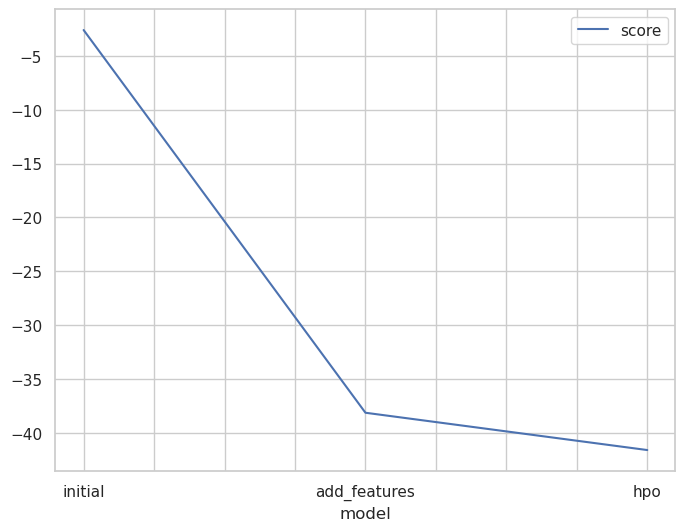

In [58]:
# Taking the top model score from each training run and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [
            predictor.leaderboard(silent=True)['score_val'][0],
            predictor_new_features.leaderboard(silent=True)['score_val'][0],
            predictor_new_hpo.leaderboard(silent=True)['score_val'][0]
        ]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

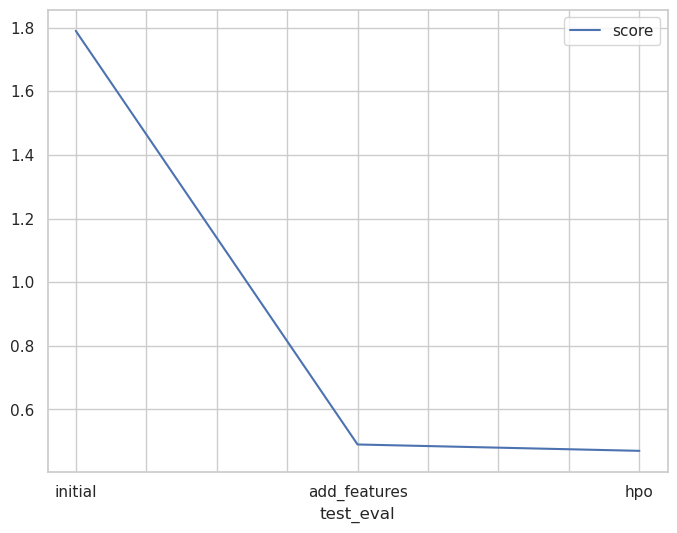

In [60]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [1.79, 0.49, 0.47]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

### Hyperparameter table

In [64]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "hpo1": ["default", "default", "XGB"],
    "hpo2": ["default", "default", "CAT"],
    "hpo3": ["default", "default", "GBM"],
    "score": [1.79, 0.49, 0.47]
})

,model,hpo1,hpo2,hpo3,score
0,initial,default,default,default,1.79
1,add_features,default,default,default,0.49
2,hpo,XGB,CAT,GBM,0.47
